## Visualizing results -  Original Geoparser

### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_Gazetteer/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def display_spacy_entities(result):
    for i in result.keys():
        for k in result[i]:
            html= k["display_doc"]
            if html:
                print(" \n ----- %s: Entities with the Spacy \"%s\" language model  ----- \n" % (k["text_unit id"], k["lang_model"]))
                display(HTML(html))

In [4]:
def display_geoparser_entities(result):
    for i in result.keys():
        for k in result[i][0:15]:
            ER= k["display_ER"]
            print(" %s -- Clean Text: %s \n" %( k["text_unit id"], k["clean_text"]))
            if ER:
                print(" --> \t %s -- Entities with the Original Geoparser: \n" % k["text_unit id"])
                for ent in ER[2:]:
                    print("%s (p:%s, group:%s)" %(ent[0], ent[1]["p"], ent[1]["group"]), end='', flush=True)
                print("\n")
         

In [5]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [6]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [7]:
def label_freq_places(df_total, df_max_geolocations):
    place_label=[]
    place_freq = []
    for i in range(0,15):
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        print(i, place_count,place_name)
        place_label.append(place_name)
        place_freq.append(place_count)
    return place_label, place_freq

In [8]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq, color='orange')
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, place_label, rotation=40)
    plt.title('15 Places most mentioned using the Original Geoparser')
    #plt.show()
    plt.savefig('Original.png', dpi=300)


We run the *geoparser_pages* defoe query over "Descriptive account of the principal towns in Scotland - 1828"* gazetter using the original nltk language model.

    spark-submit --py-files defoe.zip defoe/run_query.py nls-gaz-demo.txt nls defoe.nls.queries.geoparser_pages -r geoparser_97350713_ER -n 16
 
Note: We just perfomed this study using all the pages of one book. Therefore, the *nlz-gaz-demo.txt* only has one directory: XXXX/nls-data-gazetteersOfScotland/97350713. But we could run this query using the full dataset (which will include all the directories).

This query does the following tasks:

- Ingests all the pages from the directory "97350713",  which corresponds to the book "Descriptive account of the principal towns in Scotland - 1828"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* running spacy over the cleaned text using the language model specified in lang_model.yml ("en" | "en_core_web_lg")
- From the previous entities, just selects the one about *location* (GPE, LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve (from the Edinburgh Geoparser) to each xml and gets lat and long. 
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * display_ER: Display of a page’s entities found by the geoparser (in HTML format)
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver to the page’s  locations by NLTK
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. In this case, number of pages of this particular gazetter (e.g. 376)
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Gazetter's year 


Example:

    - "Descriptive account of the principal towns in Scotland: to accompany Wood''s town atlas':
        - archive_filename: /home/tdm/datasets/nls-data-gazetteersOfScotland/97350713
          clean_text: "Xll Greenock, 171 Haddington, 181 Hamilton, ..."
          display_ER: 
               - - Greenock
                    - group: I-NP
                      id: w20
                      locname: single
                      p: NNP
                      pws: 'yes'
                 ....
          edition: '1828'
          georesolution_page:
              georesolution_page:
                Haddington-rb1:
                    - '55.95547563598544'
                    - '-2.786118571914091'
                Hamilton-rb2:
                    - '55.77596504861518'
                    - '-4.034246035555355'
          ....
          lang_model: geoparser_original
          model: nls
          num_text_unit: 376
          page_filename: alto/97350923.34.xml
          place: Edinburgh
          text_unit: page
          text_unit id: Page18
          type_distribution: book
          year: 1828


In [9]:
results=read_query_results('geoparser_97350713_ER')

In [10]:
display_geoparser_entities(results)

 Page1 -- Clean Text:  

 --> 	 Page1 -- Entities with the Original Geoparser: 



 Page2 -- Clean Text: -A , 12-2. 6-, S/hjrvv^^2 v*cptld0-9»*- 

 --> 	 Page2 -- Entities with the Original Geoparser: 

- (p::, group:O)A (p:DT, group:O), (p:,, group:O)12-2 (p:CD, group:B-NP). (p:., group:O)6 (p:CD, group:O)- (p::, group:O), (p:,, group:O)S (p:NNP, group:B-NP)/ (p:NNP, group:I-NP)hjrvv (p:NNP, group:I-NP)^ (p:NNP, group:I-NP)^ (p:VBD, group:B-VP)2 (p:CD, group:B-NP)v (p:NN, group:I-NP)* (p:NN, group:I-NP)cptld0-9 (p:JJ, group:B-NP)» (p:NN, group:I-NP)* (p:NN, group:I-NP)- (p::, group:O)

 Page3 -- Clean Text: f 4-! ,\ Tioos ' 

 --> 	 Page3 -- Entities with the Original Geoparser: 

f (p:LS, group:B-NP)4 (p:LS, group:I-NP)- (p::, group:O)! (p:., group:O), (p:,, group:O)\ (p:NNP, group:B-NP)Tioos (p:NNP, group:I-NP)' (p:POS, group:I-NP)

 Page4 -- Clean Text: Digitized by the Internet Archive in 2012 http://archive.org/details/descriptiveacc1828scot 

 --> 	 Page4 -- Entities with the Or

IV (p:NNP, group:B-NP)of (p:IN, group:B-PP)the (p:DT, group:B-NP)most (p:RBS, group:I-NP)remarkable (p:JJ, group:I-NP)events (p:NNS, group:I-NP)recorded (p:VBN, group:B-VP)in (p:IN, group:B-PP)our (p:PRP$, group:B-NP)historic (p:JJ, group:I-NP)annals (p:NNS, group:I-NP); (p::, group:O)but (p:CC, group:O)presents (p:NNS, group:B-NP), (p:,, group:O)in (p:IN, group:B-PP)the (p:DT, group:B-NP)striking (p:JJ, group:I-NP)improvements (p:NNS, group:I-NP)of (p:IN, group:B-PP)modern (p:JJ, group:B-NP)times (p:NNS, group:I-NP), (p:,, group:O)a (p:DT, group:B-NP)spectacle (p:NN, group:I-NP)highly (p:RB, group:B-ADVP)gratifying (p:VBG, group:B-VP)to (p:TO, group:B-PP)the (p:DT, group:B-NP)Philanthropist (p:NNP, group:I-NP), (p:,, group:O)and (p:CC, group:O)to (p:TO, group:B-PP)all (p:DT, group:O)who (p:WP, group:B-NP)are (p:VBP, group:B-VP)interested (p:JJ, group:B-ADJP)in (p:IN, group:B-PP)the (p:DT, group:B-NP)science (p:NN, group:I-NP)of (p:IN, group:B-PP)Political (p:JJ, group:B-NP)Economy (p:

LIST (p:JJ, group:B-ADJP)OF (p:IN, group:B-PP)SUBSCRIBERS (p:NNS, group:B-NP). (p:., group:O)His (p:PRP$, group:B-NP)Grace (p:NN, group:I-NP)the (p:DT, group:B-NP)Duke (p:NNP, group:I-NP)of (p:IN, group:I-NP)Gordon (p:NNP, group:I-NP), (p:,, group:O)His (p:PRP$, group:B-NP)Grace (p:NN, group:I-NP)the (p:DT, group:B-NP)Duke (p:NNP, group:I-NP)of (p:IN, group:I-NP)Argyll (p:NNP, group:I-NP), (p:,, group:O)His (p:PRP$, group:B-NP)Grace (p:NN, group:I-NP)the (p:DT, group:B-NP)Duke (p:NNP, group:I-NP)of (p:IN, group:I-NP)Buccleueh (p:NNP, group:I-NP)and (p:CC, group:O)Queensberry (p:NNP, group:B-NP), (p:,, group:O)The (p:DT, group:B-NP)Right (p:NNP, group:I-NP)Honourable (p:NNP, group:I-NP)Lord (p:NNP, group:I-NP)Montague (p:NNP, group:I-NP), (p:,, group:O)The (p:DT, group:B-NP)Right (p:NNP, group:I-NP)Honourable (p:NNP, group:I-NP)the (p:DT, group:B-NP)Earl (p:NNP, group:I-NP)of (p:IN, group:I-NP)Rosslyn (p:NNP, group:I-NP), (p:,, group:O)The (p:DT, group:B-NP)Right (p:NNP, group:I-NP)Hono

In [11]:
df_total= geresolution_dataframe(results)

In [12]:
df_total

,Latitude,Longitude,Place,Page
0,55.9251525946208,-3.284768133955424,EDINBURGH,Page7
1,57.68633318560074,-4.96890721218449,Scotland,Page9
2,-18.8,29.6666667,Sir Walter Scott,Page13
3,48.199790421,-91.68354363,Bart,Page13
4,49.05597239846705,-122.3211206671363,Abbotsford,Page13
5,57.58856400682742,-2.495075726851453,Hillton,Page14
6,56.99158324302653,-2.24231921120062,Ury,Page14
7,57.64555477355096,-3.316752816442518,Elgin,Page17
8,56.56318329274704,-2.593864847361574,Arbroath,Page17
9,56.07191979883905,-3.439302694198069,Dunfermline,Page17


In [13]:
df_total[["Place"]].count()

Place    2284
dtype: int64

In [14]:
df_total.sum()

Latitude     55.925152594620857.68633318560074-18.848.19979...
Longitude    -3.284768133955424-4.9689072121844929.6666667-...
Place        EDINBURGHScotlandSir Walter ScottBartAbbotsfor...
Page         Page7Page9Page13Page13Page13Page14Page14Page17...
dtype: object

In [15]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
ABERDEEN,2,2,2
ANNAN,1,1,1
ARBROATH,1,1,1
AYR,1,1,1
Abbey Craig,1,1,1
Abbey Hill,1,1,1
Abbotsford,1,1,1
Aberbrothock,1,1,1
Abercairnie,1,1,1


In [16]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page100,7,7,7
Page101,8,8,8
Page102,11,11,11
Page103,8,8,8
Page104,1,1,1
Page105,12,12,12
Page106,4,4,4
Page107,4,4,4
Page108,10,10,10


In [17]:
df_total.groupby(["Latitude", "Longitude"]).count()

,,Place,Page
Latitude,Longitude,,
,,46,46
-10.48565032344342,105.6168319019587,1,1
-13.1102778,39.0794444,1,1
-16.33333,-68,1,1
-18.2,31.0833333,1,1
-18.8,29.6666667,3,3
-20.4666667,141.7833333,1,1
-21.76168181758405,-58.16576087147877,3,3
-23.5166667,27.8333333,1,1


In [18]:
df_max_geolocations= df_total[['Latitude','Longitude', 'Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     


df_max_geolocations.head(15)

,Place,count
569,Scotland,128
237,Edinburgh,113
288,Glasgow,75
391,Leith,61
155,Clyde,36
515,Perth,35
42,Ayr,32
412,London,32
10,Aberdeen,29
223,Dundee,27


In [19]:
#Getting the 15 places (and their frequencies) most mentioned
place_label= df_max_geolocations['Place'].tolist()[0:15]
place_freq= df_max_geolocations['count'].tolist()[0:15]


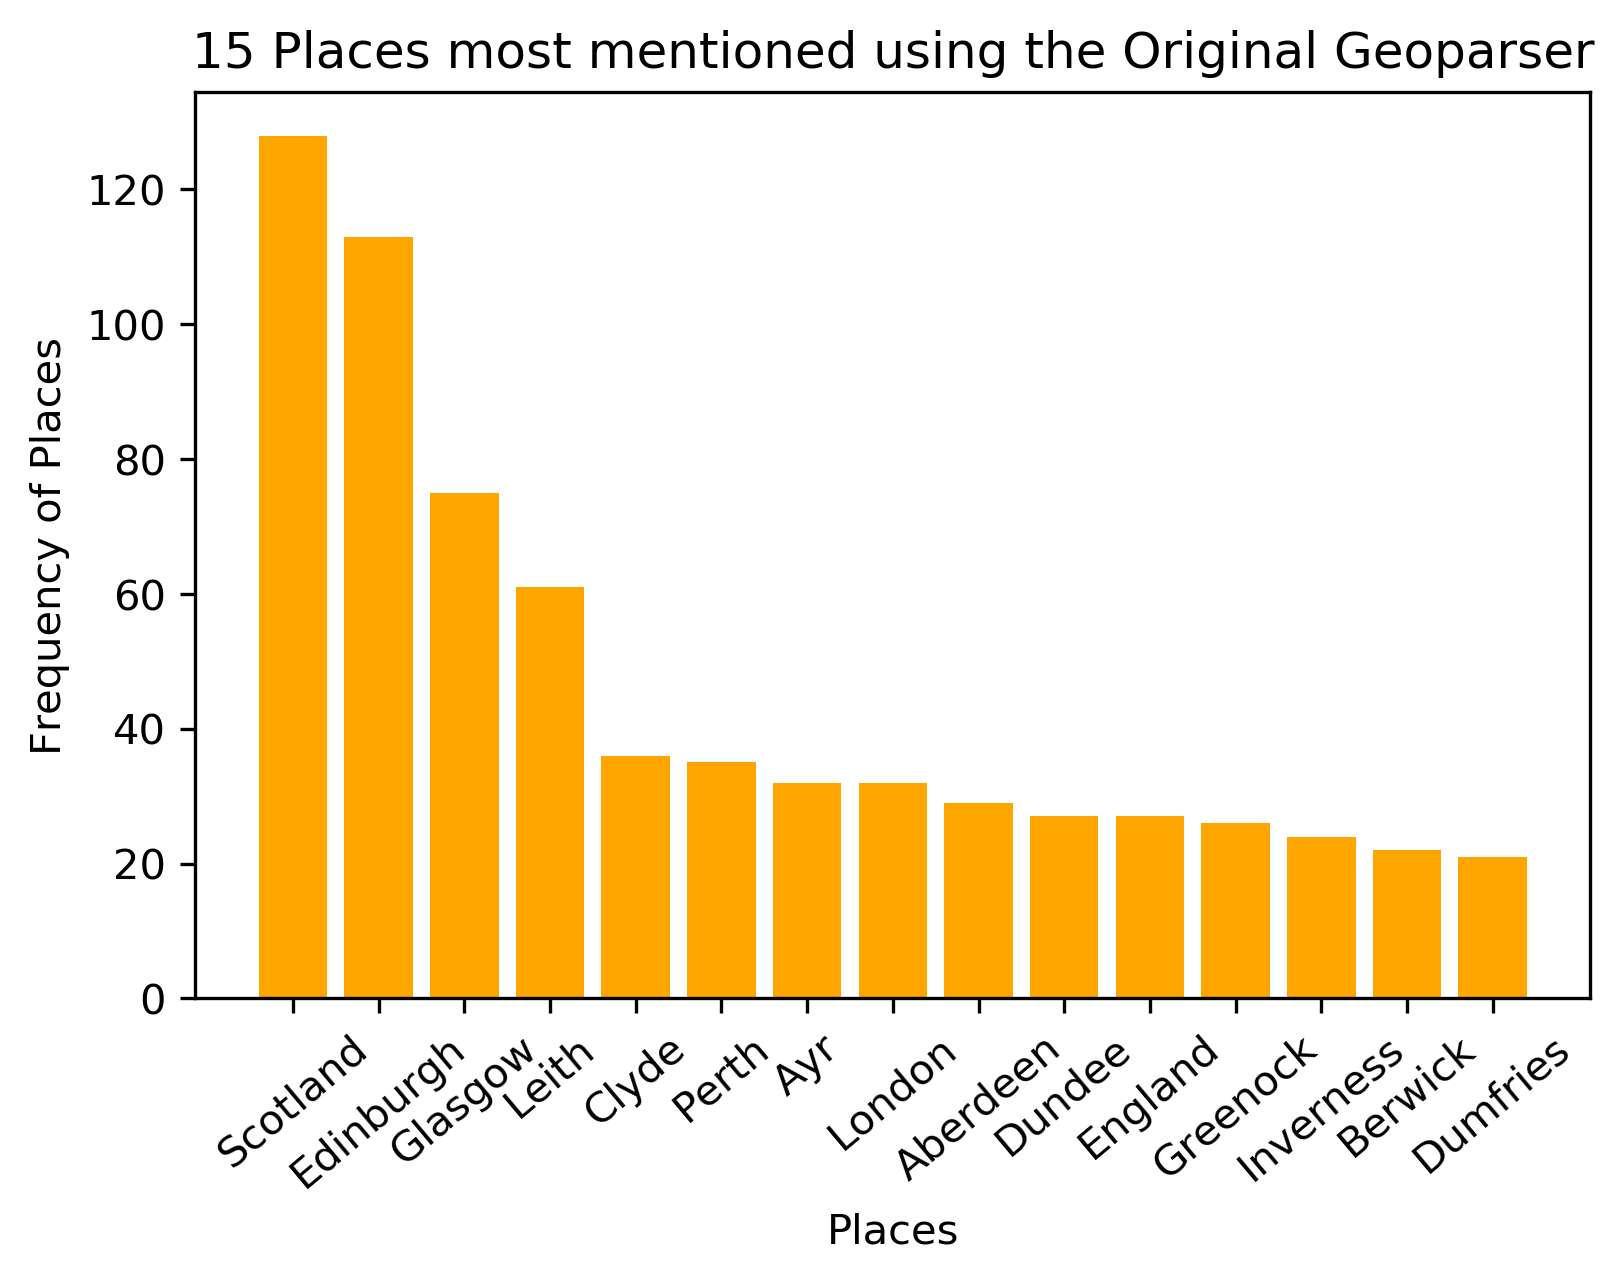

In [20]:
#Visualizing the 15 places in a Bar plot
mpl.rcParams['figure.dpi']=300
plot_bar_places(place_label, place_freq)